# Hidden fees

 Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import requests
import datetime
from scrapy import Selector

Import necessary Bokeh functions.

*Note:* To install Bokeh, run `conda install bokeh` in your Anaconda prompt

In [2]:
from bokeh.io import output_file, show, output_notebook, curdoc
from bokeh.plotting import figure
from bokeh.models import CategoricalColorMapper, ColumnDataSource, CustomJS, Select, NumeralTickFormatter, HoverTool, FactorRange
from bokeh.layouts import widgetbox, column, row
from bokeh.models.widgets import RadioButtonGroup, DataTable, TableColumn, NumberFormatter, TextInput, Div
from bokeh.transform import dodge
from bokeh.core.properties import value

We merge the exchange rates offered by banks with market rates and save the results.

In [4]:
bank_rates = pd.read_csv("bank_rates.csv", encoding='utf-8', names=["from", "to", "rate", "bank", "date"], header = None)
bank_rates.rate = bank_rates.rate.astype(float)

market_rates = pd.read_csv("market_rates.csv", encoding='utf-8', names=["from", "to", "market_rate","date"], header=None)
market_rates.market_rate = market_rates.market_rate.astype(float)

merged = pd.merge(bank_rates, market_rates, how = "left", on = ["from", "to", "date"])
merged["hidden_fee"] = merged["market_rate"] - merged["rate"]
merged = merged.drop_duplicates()
merged.to_csv("merged_df.csv", encoding='utf-8', index=False)


## Analysis of hidden fees
Here we test what factors predict the amount of hidden fees. First, we define fee markup variable that gives us the fee as a precentage of the current mid-market rate. This enables us to compare hidden fees across different exchange rate routes and banks. 

In [5]:
merged["fee_markup"] = merged["hidden_fee"]/merged["market_rate"] * 100

Second, we calculate average fee markup and coefficient of variation in the mid-market exchange for each route and bank.

In [6]:
def coef_of_var(x):
    return np.std(x)/np.mean(x) * 100

avg_fees = merged.groupby(["from", "to", "bank"], as_index = False).agg({"fee_markup": np.mean, "market_rate": coef_of_var})
avg_fees.head(10)

,from,to,bank,fee_markup,market_rate
0,AUD,CZK,Fio banka,2.464499,0.965001
1,AUD,CZK,Komerční banka,2.766920,0.965001
2,AUD,CZK,Raiffeisenbank,3.116176,0.965001
3,AUD,CZK,mBank,2.995142,0.965001
4,AUD,CZK,ČSOB,2.561096,0.959612
5,AUD,CZK,Česká spořitelna,2.494193,0.950286
6,AUD,EUR,Slovenská sporiteľňa,1.448194,1.097144
7,AUD,EUR,Tatra banka,1.394964,1.095938
8,AUD,EUR,VÚB banka,1.468966,1.095938
9,AUD,HUF,OTP Bank,1.016527,0.561851


##### Import the plotnine package

*Note:* To install plotnine either run `conda install -c conda-forge plotnine` or run `pip install plotnine` in the shell.

In [7]:
from plotnine import *

##### Histogram of hidden fee markups

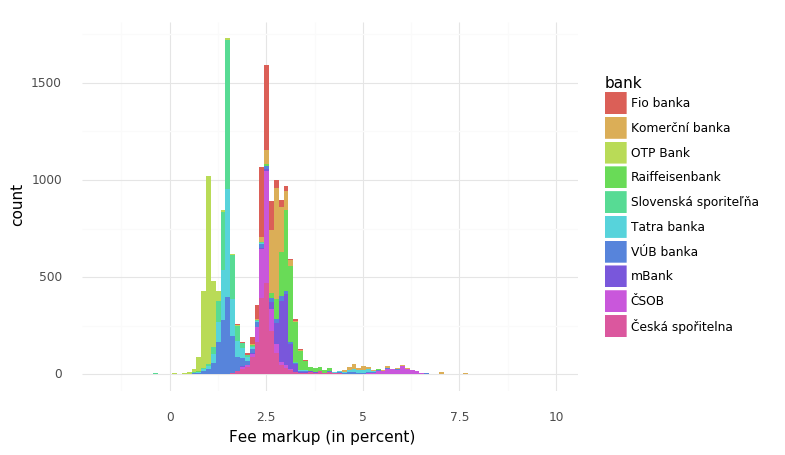

<ggplot: (-9223371915389638512)>

In [8]:
(ggplot(merged, aes(x = "fee_markup", fill = "bank")) +
 geom_histogram(bins = 93) + 
 labs(x = "Fee markup (in percent)") + 
 theme_minimal())

The following plot shows that there are substantial differences in size of hidden fees across banks. Interstingly, the Czech bank appear to have higher markups compared to the Slovakian banks (VÚB banka, Tatra banka, Slovenská sporiteľňa) and one Hungarian bank (OTP bank) in the dataset.

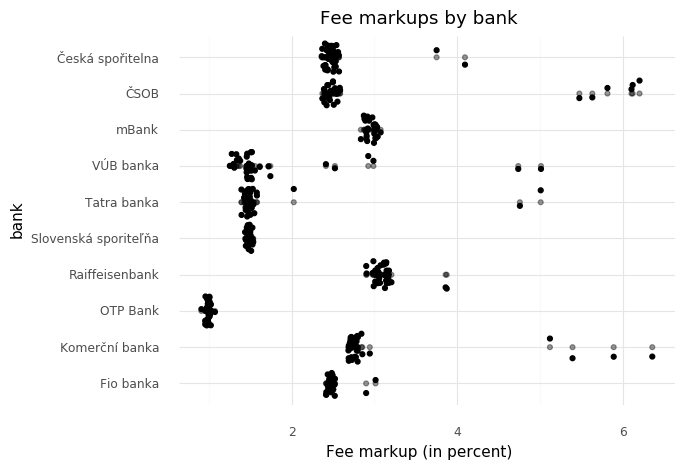

<ggplot: (-9223371915388593415)>

In [9]:
(ggplot(avg_fees, aes(x = "bank", y = "fee_markup")) +
 geom_point(alpha = 0.4) + 
 geom_jitter() + 
 coord_flip() + 
 labs(y = "Fee markup (in percent)", title = "Fee markups by bank") + 
 theme_minimal())

Below, we create a scatter plot showing the relation between the market exchange rate volatility and hidden fee markups together with a best-fit line from simple linear regression model. We can see that the relation appears to be positive, although the market rate seems to explain only small fraction of variation in fee markups. Furthermore, the plot suggests that there might be heteroskedaticity present in the model.  

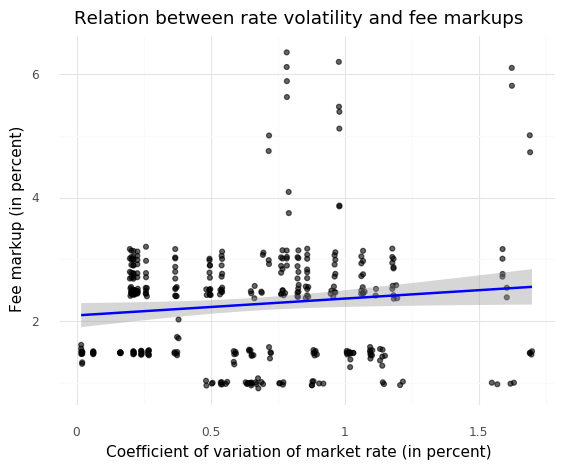

<ggplot: (-9223371915388464608)>

In [10]:
(ggplot(avg_fees, aes(x = "market_rate", y = "fee_markup")) +
 geom_point(alpha = 0.6) + 
 geom_smooth(method = "lm", color = "blue") + 
 labs(y = "Fee markup (in percent)", x = "Coefficient of variation of market rate (in percent)", 
      title = "Relation between rate volatility and fee markups") + 
 theme_minimal())

#### Bank vs market rate comparisons by bank

We load the BokehJS notebook

In [11]:
output_notebook()

Loading BokehJS ...

In [12]:
def modify_doc0(doc):
    # Import the data
    rates = pd.read_csv("merged_df.csv", encoding='utf-8')

    mean_fees = rates.groupby(["from", "to", "bank"], as_index = False).agg("mean")
    mean_fees["from_to"] = mean_fees["from"] + " to " + mean_fees["to"]
    mean_fees["bank_to_market_rate"] = mean_fees["rate"] / mean_fees["market_rate"] * 100

    bank = "Česká spořitelna"
    data_filtered = mean_fees[mean_fees.bank == bank].sort_values("bank_to_market_rate")

    source = ColumnDataSource(data={"from_to" : data_filtered.from_to,
                                    "bank" : data_filtered.bank,
                                    "bank_to_market_rate" : data_filtered.bank_to_market_rate})

    from_to_options = data_filtered.from_to.unique().tolist()
    
    bank_options = mean_fees.bank.unique().tolist()
    select_bank = Select(title="Bank:", value="Česká spořitelna", options = bank_options)
    
    
    def callback(attr, old, new):
        bank_updated = select_bank.value
        
        data_filtered_updated = mean_fees[mean_fees.bank == bank_updated].sort_values("bank_to_market_rate")
        
        source.data = {"from_to" : data_filtered_updated.from_to,
                       "bank" : data_filtered_updated.bank,
                       "bank_to_market_rate" : data_filtered_updated.bank_to_market_rate}
        
        from_to_options_updated = data_filtered_updated.from_to.unique().tolist()
        
        p.y_range.factors = [] 
        p.y_range.factors = from_to_options_updated
        
        
    # This code ensures that the callback function "listens" to the selectors  
    select_bank.on_change("value", callback)

    p = figure(y_range=from_to_options, x_range=(70, 105), plot_height=620, title="Bank and market rates compared")
   
    p.hbar(y=dodge('from_to', 0, range=p.y_range), right='bank_to_market_rate', height=0.2, source=source,
           color="#e84d60")
    
    # Define the layout of the app
    layout = column(select_bank,  p)
    
    
    # Add the plot to the current document
    doc.add_root(layout)

show(modify_doc0)

In [13]:
def modify_doc01(doc):
    # Import the data
    rates = pd.read_csv("merged_df.csv", encoding='utf-8')

    mean_fees = rates.groupby(["from", "to", "bank"], as_index = False).agg("mean")
    mean_fees["from_to"] = mean_fees["from"] + " to " + mean_fees["to"]

    bank = "Česká spořitelna"
    data_filtered = mean_fees[mean_fees.bank == bank].sort_values("market_rate")

    source = ColumnDataSource(data={"from_to" : data_filtered.from_to,
                                    "bank" : data_filtered.bank,
                                    "bank_rate" : data_filtered.rate,
                                    "market_rate" : data_filtered.market_rate})

    from_to_options = data_filtered.from_to.unique().tolist()
    
    bank_options = mean_fees.bank.unique().tolist()
    select_bank = Select(title="Bank:", value="Česká spořitelna", options = bank_options)
    
    
    def callback(attr, old, new):
        bank_updated = select_bank.value
        
        data_filtered_updated = mean_fees[mean_fees.bank == bank_updated].sort_values("market_rate")
        
        source.data = data={"from_to" : data_filtered_updated.from_to,
                            "bank" : data_filtered_updated.bank,
                            "bank_rate" : data_filtered_updated.rate,
                            "market_rate" : data_filtered_updated.market_rate}
        
        from_to_options_updated = data_filtered_updated.from_to.unique().tolist()
        
        p.y_range.factors = [] 
        p.y_range.factors = from_to_options_updated
        
        p.x_range.start = 0
        p.x_range.end = source.data["rate"].max() * 1.05
        
        
    # This code ensures that the callback function "listens" to the selectors  
    select_bank.on_change("value", callback)

    p = figure(y_range=FactorRange(factors=from_to_options), plot_height=620, 
               title="Comparison of average bank rate and average mid-market rate")
   
    p.hbar(y=dodge('from_to', -0.15, range=p.y_range), right='bank_rate', height=0.2, source=source,
           color="#c9d9d3", legend=value("Bank rate"))

    p.hbar(y=dodge('from_to', 0.15, range=p.y_range), right='market_rate', height=0.2, source=source,
           color="#e84d60", legend=value("Market rate"))
    
    p.legend.location = "bottom_right"

    
    # Define the layout of the app
    layout = column(select_bank,  p)
    
    
    # Add the plot to the current document
    doc.add_root(layout)

show(modify_doc01)

In [14]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

We now move on to fitting the models.

We start by simple linear model. The results show that the effect of the market rate volatility on hidden fee markups is postive and significantly different from zero at 10 percent level. Nevertheless, the R-squared of the model is only 0.008 which indicates that markup volatility by itself can explain only small fraction of variability in the fee markups.

In [15]:
mod_simple = smf.ols(formula='fee_markup ~ market_rate', data=avg_fees)
results_simple = mod_simple.fit()

results_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fee_markup   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4.312
Date:                Tue, 28 May 2019   Prob (F-statistic):             0.0386
Time:                        22:00:45   Log-Likelihood:                -496.71
No. Observations:                 354   AIC:                             997.4
Df Residuals:                     352   BIC:                             1005.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.0935      0.101     20.667      0.000       1.894       2.293
market_rate     0.2724      0.131      2.076      0.039       0.014       0.530
==============================================================================
Omnibus:                       79.317   Durbin-Watson:                   1.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              178.529
Skew:                           1.123   Prob(JB):                     1.71e-39
Kurtosis:                       5.657   Cond. No.                         3.72
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In our second model, we add dummy variables for each bank. This improves the fit of the model considerably. Moreover, coefficient on rate volatility is still positive (even slightly larger) and significant. However, the standard errors of the model could be biased due to the potential heteroskedasticity. For this reason, we refit the model with heteroskedasticity robust SE. 

In [16]:
mod = smf.ols(formula='fee_markup ~ market_rate + C(bank)', data=avg_fees)
results = mod.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fee_markup   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     53.75
Date:                Tue, 28 May 2019   Prob (F-statistic):           3.24e-64
Time:                        22:01:03   Log-Likelihood:                -332.00
No. Observations:                 354   AIC:                             686.0
Df Residuals:                     343   BIC:                             728.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           2.2608      0.130     17.412      0.000       2.005       2.516
C(bank)[T.Komerční banka]           0.5681      0.158      3.590      0.000       0.257       0.879
C(bank)[T.OTP Bank]                -1.5797      0.153    -10.357      0.000      -1.880      -1.280
C(bank)[T.Raiffeisenbank]           0.6013      0.156      3.844      0.000       0.294       0.909
C(bank)[T.Slovenská sporiteľňa]    -1.0126      0.156     -6.475      0.000      -1.320      -0.705
C(bank)[T.Tatra banka]             -0.8075      0.160     -5.039      0.000      -1.123      -0.492
C(bank)[T.VÚB banka]               -0.7109      0.158     -4.493      0.000      -1.022      -0.400
C(bank)[T.mBank]                    0.4445      0.175      2.544      0.011       0.101       0.788
C(bank)[T.ČSOB]                     0.5574      0.160      3.477      0.001       0.242       0.873
C(bank)[T.Česká spořitelna]         0.0309      0.153      0.202      0.840      -0.270       0.332
market_rate                         0.3905      0.084      4.633      0.000       0.225       0.556
==============================================================================
Omnibus:                      276.933   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3167.348
Skew:                           3.376   Prob(JB):                         0.00
Kurtosis:                      16.006   Cond. No.                         14.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The heteroskedasticity robust are indeed slightly larger than their non-robust counterparts. However, the effect of market rate volatility still remains significant.

In [17]:
result_robust = results.get_robustcov_results()
result_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fee_markup   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     547.0
Date:                Tue, 28 May 2019   Prob (F-statistic):          4.79e-204
Time:                        22:01:09   Log-Likelihood:                -332.00
No. Observations:                 354   AIC:                             686.0
Df Residuals:                     343   BIC:                             728.6
Df Model:                          10                                         
Covariance Type:                  HC1                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           2.2608      0.075     29.946      0.000       2.112       2.409
C(bank)[T.Komerční banka]           0.5681      0.158      3.592      0.000       0.257       0.879
C(bank)[T.OTP Bank]                -1.5797      0.042    -37.362      0.000      -1.663      -1.497
C(bank)[T.Raiffeisenbank]           0.6013      0.048     12.530      0.000       0.507       0.696
C(bank)[T.Slovenská sporiteľňa]    -1.0126      0.044    -22.776      0.000      -1.100      -0.925
C(bank)[T.Tatra banka]             -0.8075      0.146     -5.548      0.000      -1.094      -0.521
C(bank)[T.VÚB banka]               -0.7109      0.134     -5.319      0.000      -0.974      -0.448
C(bank)[T.mBank]                    0.4445      0.044     10.041      0.000       0.357       0.532
C(bank)[T.ČSOB]                     0.5574      0.214      2.599      0.010       0.136       0.979
C(bank)[T.Česká spořitelna]         0.0309      0.062      0.501      0.617      -0.091       0.152
market_rate                         0.3905      0.110      3.539      0.000       0.173       0.608
==============================================================================
Omnibus:                      276.933   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3167.348
Skew:                           3.376   Prob(JB):                         0.00
Kurtosis:                      16.006   Cond. No.                         14.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

## Historical exchange rates by currency and bank
In this part, we built a Bokeh application in which the user can choose a route and bank and the app will show the historical exchange rates. 

We define the Bokeh app

In [18]:
def modify_doc(doc):
    # Import the data
    rates = pd.read_csv("merged_df.csv", encoding='utf-8')
    rates['date'] = pd.to_datetime(rates['date'])
    rates = rates.rename(columns={'from':'from_cur', 'to':'to_cur'})
    
    # Set the inital exchange rate and bank
    from_currency = "EUR"
    to_currency = "CZK"
    bank = "Česká spořitelna"

    # Filter the dataset
    data_filtered = rates[(rates["from_cur"] == from_currency) & (rates["to_cur"] == to_currency)&
                         (rates["bank"] == bank)]
    
    # Convert the dataset to ColumnDataSource (a format that is more suitable for Bokeh)
    source = ColumnDataSource(dict(date = data_filtered.date, from_cur = data_filtered.from_cur,
                                   to_cur = data_filtered.to_cur, rate = data_filtered.rate, 
                                  bank = data_filtered.bank))
    currency_options_source = ColumnDataSource(dict(from_options = rates[rates.bank == bank].from_cur.unique().tolist(),
                                                    to_options = rates[rates.bank == bank].to_cur.unique().tolist()))
    
    # Here we make the plot itself 
    plot_it = figure(plot_width=800, plot_height=250, x_axis_type="datetime", title = "Exchange rate", 
                    x_axis_label= 'Date', y_axis_label = "Rate")
    plot_it.line(x = 'date', y = "rate", line_width = 3 , source = source)
    
    # Add hovertool (a box that shows the rate and date of the point over which mouse hovers in the moment)  
    plot_it.add_tools(HoverTool(
        tooltips=[("rate", "@rate"), ("date", "@date{%F}")],
        formatters={'date': 'datetime'},
        mode = "vline"))
  
        
    # Define options for the selectors    
    bank_options = rates.bank.unique().tolist()
    from_options = currency_options_source.data.get("from_options")
    to_options = currency_options_source.data.get("to_options")

    # Define the selectors themselves
    select_from_currency = Select(title="From:", value="EUR", options = from_options)
    select_to_currency   = Select(title="To:", value="CZK", options = to_options)
    select_bank          = Select(title="Bank:", value="Česká spořitelna", options = bank_options)
     
        
    # We define a Bokeh callback function which take the values from the selctors and update the ColumnDataSource         
    def callback(attr, old, new):
        from_currency_updated = select_from_currency.value
        to_currency_updated = select_to_currency.value
        bank_updated = select_bank.value
        
        data_filtered = rates[(rates["from_cur"] == from_currency_updated) & (rates["to_cur"] == to_currency_updated) &
                              (rates["bank"] == bank_updated)]
        source.data = {"date" : data_filtered.date, "to_cur" : data_filtered.to_cur, "from_cur" : data_filtered.from_cur, 
                       "rate" : data_filtered.rate,
                       "bank": data_filtered.bank}
        
        currency_options_source.data = {"from_options": rates[rates.bank == bank_updated].from_cur.unique().tolist(),
                                        "to_options": rates[rates.bank == bank_updated].to_cur.unique().tolist()}
        from_options = currency_options_source.data.get("from_options")
        to_options = currency_options_source.data.get("to_options")    
      
        
        
    # This code ensures that the callback function "listens" to the selectors  
    select_from_currency.on_change("value", callback)
    select_to_currency.on_change("value", callback)
    select_bank.on_change("value", callback)

    # Define the layout of the app
    layout = column(row(select_bank, select_from_currency, select_to_currency), plot_it)
    
    
    # Add the plot to the current document
    doc.add_root(layout)

### Show the app
*Be aware that for banks do not offer all currency pairs in the list.*

In [19]:
show(modify_doc)

## Hidden fees by bank
This Bokeh application allows the user to select a route, amount to exchange, and date and then compares hidden fees by banks and shows which bank offers the best exchage rate (with the lowest hidden fee).

In [20]:
def modify_doc2(doc):
    # Import data
    rates = pd.read_csv("merged_df.csv", encoding='utf-8')
    rates['date'] = pd.to_datetime(rates['date'])

    # Set initial currencies, amount to exchange, and date
    from_currency = "EUR"
    to_currency = "CZK"
    amount_to_exchange = 1
    most_recent_date = rates['date'].max()
    
    # Filter the data accordingly
    data_filtered = rates[(rates["from"] == from_currency) & (rates["to"] == to_currency) 
                          & (rates['date'] == most_recent_date)]
    
    # Sort by amount of hidden fees
    data_filtered = data_filtered.sort_values('hidden_fee')
    
    # Select bank with the lowest hidden fee
    lowest_fee_bank = data_filtered.iloc[0, 3]
    
    # Create the ColumnDataSource
    source = ColumnDataSource(dict(date = data_filtered.date, to = data_filtered.to, 
                                   rate = data_filtered.rate, 
                                   bank = data_filtered.bank,
                                   market_rate = data_filtered.market_rate, 
                                   hidden_fee = data_filtered.hidden_fee))
    
    # Amount of foreign currency and hidden fee we will get from the baest exhange rate 
    # Note that data is already sorted by hidden fee and thus choosing the first row gets us the lowest hidden fee rate
    amount_of_foreign_cur =str(round(data_filtered.iloc[0, 2] * amount_to_exchange, 3))
    amount_hidden_fee = str(round(data_filtered.iloc[0, 6] * amount_to_exchange, 3))
    
    # Text that shows which bank offers the best echange rate, amount you will get, and hidden fee
    text_to_display = """<font size="+1"> The best exchange rate is offered by 
    <b>""" + lowest_fee_bank + """
    </b>. <br> You will get <b>"""+  amount_of_foreign_cur + " " + to_currency + \
    """</b>. <br> The hidden fee is <b>""" + amount_hidden_fee + " " + to_currency + """</b>."""
    
    
    # Set the options for the selectors
    banks_available = source.data["bank"].tolist()
    from_options = rates["from"].unique().tolist()
    to_options = rates["to"].unique().tolist()
    # Note that we have to convert the dates to string
    date_options = [dt.strftime("%b %d, %Y") for dt in list(sorted(set(rates["date"].tolist())))]
    
    # Define the selctors and text input that takes in the amount for exchange
    select_from_currency = Select(title="From:", value="EUR", options = from_options)
    select_to_currency   = Select(title="To:", value="CZK", options = to_options)
    select_date          = Select(title="Date:", value=most_recent_date.strftime("%b %d, %Y"), options = date_options)
    text_input_amount = TextInput(title="Amount for exchange:", value="1")


    # Define the Bokeh callback function
    def callback(attr, old, new):
        from_currency_updated = select_from_currency.value
        to_currency_updated = select_to_currency.value
        # Here we convert the date from the selector back to datetime format
        date_updated = datetime.datetime.strptime(select_date.value, "%b %d, %Y") 
        amount_to_exchange_updated = float(text_input_amount.value)
        
        # Filter the data based on the new inputs
        data_filtered_update = rates[(rates["from"] == from_currency_updated) & (rates["to"] == to_currency_updated)
                                    & (rates['date'] == date_updated)]
        
        data_filtered_update = data_filtered_update.sort_values('hidden_fee')
        
        lowest_fee_bank_update = data_filtered_update.iloc[0, 3]
        amount_of_foreign_cur =str(round(data_filtered_update.iloc[0, 2] * amount_to_exchange_updated, 3))
        amount_hidden_fee = str(round(data_filtered_update.iloc[0, 6] * amount_to_exchange_updated, 3))
        
        # Update the ColumnDataSource based on the new inpunts
        source.data = {"date" : data_filtered_update.date, "to" : data_filtered_update.to,
                       "rate" : data_filtered_update.rate, 
                       "bank" : data_filtered_update.bank, 
                       "market_rate" : data_filtered_update.market_rate, 
                       "hidden_fee" : data_filtered_update.hidden_fee}
       
        # We update the range such that it would always start at 0 zero and extend to 1.05 of the maximum hidden fee
        plot_it.x_range.start = 0
        plot_it.x_range.end = source.data["hidden_fee"].max() * 1.05
        
        # We uptade the new values in the displayed text
        text_to_display_update = """<font size="+1"> The best exchange rate is offered by <b>""" + lowest_fee_bank_update+\
        """</b>. <br> You will get <b>"""+  amount_of_foreign_cur + " " + to_currency_updated + \
        """</b>. <br> The hidden fee is <b>""" + amount_hidden_fee + " " + to_currency_updated + """</b>."""
        div.text = text_to_display_update

    # Again, we ensure that the callback function listens to the inputs    
    select_from_currency.on_change("value", callback)
    select_to_currency.on_change("value", callback)
    select_date.on_change("value", callback)
    text_input_amount.on_change("value", callback)
   

    # Make the plot itself
    plot_it = figure(y_range=banks_available, 
                     plot_height=250, toolbar_location=None, title="Hidden fees by bank")

    plot_it.hbar(y='bank', right='hidden_fee', source=source,
           line_color='white', height=0.9)
    
    # Add hovertool    
    plot_it.add_tools(HoverTool(
        tooltips=[("hidden fee", "@hidden_fee")],
        mode = "mouse"))

    # Add DataTable showing hidden fees, bank rates and market rates
    columns = [
        TableColumn(field="bank", title="Bank"),
        TableColumn(field="hidden_fee", title="Hidden fee (in foreign currency)", formatter=NumberFormatter(format="0.000")),
        TableColumn(field="rate", title="Bank rate", formatter=NumberFormatter(format="0.000")),
        TableColumn(field="market_rate", title="Market rate", formatter=NumberFormatter(format="0.000"))]

    data_table = DataTable(source=source, columns=columns, width=600, height = 280)
    
    # HTML text to display
    div = Div(text= text_to_display, width=600, height=100)
    div.on_change("text", callback)
    
    # Set the layout of the app
    layout = column(row(select_from_currency, select_to_currency), row(text_input_amount, select_date), div,
                    data_table,  plot_it)
    
    
    # Add the plot to the current document
    doc.add_root(layout)

### Show the app
*Be aware that for some currency routes no bank in the dataset offers any exchange.*

In [21]:
show(modify_doc2)